# É possível identificar o El Niño e El Niña em dados do clima usando redes complexas?

### Required Libraries

In [14]:
import netCDF4 as nc
import numpy as np
import cdsapi
import zipfile
import os
from tqdm import tqdm
import pandas as pd
import sys
import dask.dataframe as dd
import xarray as xr
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
import numpy as np
import networkx as nx
import random

### Obtaining Data

In [ ]:
base_extracted_folder_path = 'data/extracted_zip_data'

if not os.path.exists(base_extracted_folder_path):
    os.makedirs(base_extracted_folder_path)

c = cdsapi.Client()

days = [f'{i:02d}' for i in range(1, 32)]
days = ['01']
months = [f'{i:02d}' for i in range(1, 13)]
years = [str(i) for i in range(1998, 2022)]

for year in tqdm(years):

    if int(year) >= 2006:
        sensor_on_satellite = 'avhrr_on_metop_a'
    else:
        sensor_on_satellite = 'avhrr_on_noaa_15'

    zip_file_path = f'download_{year}.zip'
    extracted_folder_path = f'{base_extracted_folder_path}_{year}'
    c.retrieve(
        'satellite-sea-surface-temperature',
        {
            'version': '2_0',
            'variable': 'all',
            'format': 'zip',
            'processinglevel': 'level_3c',
            'sensor_on_satellite': sensor_on_satellite,
            'month': months,
            'day': days,
            'year': [year],
        },
        zip_file_path
    )

    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_folder_path)

    os.remove(zip_file_path)

    print(f"Data extracted to: {extracted_folder_path}")
    print(f"{zip_file_path} deleted.")

### Pre-analyzing  Data

Let's analyze a single file to check its structure.

In [2]:
data_dir_1998 = os.path.join(os.getcwd(), 'data', 'extracted_zip_data_1998')
dataset = nc.Dataset(os.path.join(data_dir_1998, '19981001120000-ESACCI-L3C_GHRSST-SSTskin-AVHRR15_G-CDR2.0_day-v02.0-fv01.0.nc'))
print(f"Variable type: {type(dataset)}")

Variable type: <class 'netCDF4._netCDF4.Dataset'>


In [3]:
sst = dataset.variables['sea_surface_temperature']
sst_data = sst[:]
print(sst_data.shape)

(1, 3600, 7200)


_sea_surface_temperature_ variable: 
- Meaning: Temperature of the skin of the ocean
- Units: K
- Valid Range: (-200, +5000)
- Scale Factor: 0.01 (factor by which raw data values are scaled)
- Type: int16
- Dimensions: (time, latitude, longitude)
- Shape: (1, 3600, 7200), which means that there is 1 time point, 3600 latitude points, and 7200 longitude points.
- Missing data is represented by -32768

In [4]:
sst = sst[:].squeeze()

lat = dataset.variables['lat'][:]
lon = dataset.variables['lon'][:]

lon_mesh, lat_mesh = np.meshgrid(lon, lat) # creates a meshgrid of latitude and longitude

# Flatten the meshgrid and the sea surface temperature data
lat_flat = lat_mesh.flatten()
lon_flat = lon_mesh.flatten()
sst_flat = sst.flatten()

data = {
    'Latitude': lat_flat,
    'Longitude': lon_flat,
    'Sea_Surface_Temperature': sst_flat
}

df = pd.DataFrame(data)

print(f"columns: {list(df.columns)}\n")

columns: ['Latitude', 'Longitude', 'Sea_Surface_Temperature']



In [5]:
#Filtering Data
df = df.dropna(subset=['Sea_Surface_Temperature']).reset_index(drop=True)
print(df.head())

    Latitude  Longitude  Sea_Surface_Temperature
0 -66.224998 -92.875000               271.290009
1 -66.175003 -94.574997               271.279999
2 -66.175003 -92.824997               271.380005
3 -66.175003 -92.724998               271.470001
4 -66.125000 -94.474998               271.339996


### Cleaning, Filtering and Merging Data

Now, we have a lot of .nc files: approximately 20 files per year, and each year is in a different folder. We'll group it into a single file, filtering unnecessary information.

In [2]:
def filter_data(data):
    data = data.dropna(subset=['Sea_Surface_Temperature'])
    data = data[data['Sea_Surface_Temperature'] != -32768]
    return data

In [2]:
def treat_data(data, year):
    data[year] = year
    return data

We need to extract all relevant info from the convoluted .nc files. We go through every downloaded file, then get the values for latitude, longitude and sea surface temperature and create a meshgrid to be able to establish the relationship between them in a simple way.

In [3]:
def concatenate_filter_treat_data():
    base_dir = os.path.join(os.getcwd(), 'data')
    output_dir = os.path.join(base_dir, 'interim_results')
    os.makedirs(output_dir, exist_ok=True)
    all_data = pd.DataFrame()
    location_dict = {}

    for year in tqdm(range(1998, 2022)):
        folder_name = f'extracted_zip_data_{year}'
        folder_path = os.path.join(base_dir, folder_name)

        data_from_year_list = []

        i = 0
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)

            dataset = xr.open_dataset(file_path)
            sst = dataset['sea_surface_temperature'].values.squeeze()
            lat = dataset['lat'].values
            lon = dataset['lon'].values

            lon_mesh, lat_mesh = np.meshgrid(lon, lat)
            lat_flat = lat_mesh.flatten()
            lon_flat = lon_mesh.flatten()
            sst_flat = sst.flatten()

            data = pd.DataFrame({
                'Latitude': lat_flat,
                'Longitude': lon_flat,
                'Sea_Surface_Temperature': sst_flat,
            })

            data_from_year_list.append(data)
            if i == 10:
                break
            i = i + 1

        data_from_year = pd.concat(data_from_year_list)
        data_from_year = filter_data(data_from_year)
        data_from_year, location_dict = treat_data(data_from_year, year, location_dict)

        all_data = pd.concat([all_data, data_from_year], ignore_index=True)

        interim_output_file = os.path.join(output_dir, 'interim_aggregated_data.csv')
        all_data.to_csv(interim_output_file, index=False)

    final_output_file = os.path.join(base_dir, 'merged_data.csv')
    all_data.to_csv(final_output_file, index=False)
    return True


In [17]:
concatenate_filter_treat_data()

  0%|          | 0/24 [00:00<?, ?it/s]

Year 1998 concluded. Length of current table is 1.44e+07


  4%|▍         | 1/24 [01:32<35:30, 92.63s/it]

RAM usage reached 99% after just 2 years, blindly concatenating them is not feasible. Let's modify the treat_data function to extract aggregated values from the year.
We will group the data by geographic location.

In [83]:
def treat_data(data, year, location_dict):

    location_ids = []

    for _, row in data.iterrows():
        lat_long = (row['Latitude'], row['Longitude'])

        if lat_long not in location_dict:
            location_dict[lat_long] = len(location_dict) + 1
        
        location_ids.append(location_dict[lat_long])

    data['location_id'] = location_ids

    grouped_data = data.groupby('location_id').mean().reset_index()

    grouped_data['year'] = year

    print(f"Year = {year}. Number of distinct locations = {len(location_dict)}", end=" || ")

    return grouped_data, location_dict

Note that the temperatures of a given year are averaged out, which let us not worry about seasonal temperature effects.

In [86]:
concatenate_filter_treat_data()

  0%|          | 0/24 [00:00<?, ?it/s]

Year = 1998. Number of distinct locations = 7828959 || 

  4%|▍         | 1/24 [06:01<2:18:39, 361.73s/it]

Year = 1999. Number of distinct locations = 11572011 || 

  8%|▊         | 2/24 [19:17<3:46:12, 616.94s/it]

Year = 2000. Number of distinct locations = 12775311 || 

 12%|█▎        | 3/24 [33:31<4:13:54, 725.47s/it]

Year = 2001. Number of distinct locations = 13488290 || 

 17%|█▋        | 4/24 [48:28<4:24:22, 793.13s/it]

Year = 2002. Number of distinct locations = 13821526 || 

 21%|██        | 5/24 [1:05:36<4:37:56, 877.70s/it]

Year = 2003. Number of distinct locations = 14000286 || 

 25%|██▌       | 6/24 [1:24:03<4:46:40, 955.60s/it]

Year = 2004. Number of distinct locations = 14144451 || 

 29%|██▉       | 7/24 [1:47:07<5:10:25, 1095.64s/it]

Year = 2005. Number of distinct locations = 14260382 || 

 33%|███▎      | 8/24 [2:06:21<4:57:08, 1114.26s/it]

Year = 2006. Number of distinct locations = 14264673 || 

 38%|███▊      | 9/24 [2:21:15<4:21:21, 1045.45s/it]

Year = 2007. Number of distinct locations = 14357586 || 

 42%|████▏     | 10/24 [2:58:09<5:28:08, 1406.29s/it]

Year = 2008. Number of distinct locations = 14395043 || 

 46%|████▌     | 11/24 [3:38:10<6:10:36, 1710.50s/it]

Year = 2009. Number of distinct locations = 14466485 || 

 50%|█████     | 12/24 [4:11:39<6:00:17, 1801.48s/it]

Year = 2010. Number of distinct locations = 14533197 || 

 54%|█████▍    | 13/24 [4:28:56<4:47:49, 1570.00s/it]

Year = 2011. Number of distinct locations = 14610935 || 

 58%|█████▊    | 14/24 [4:47:06<3:57:27, 1424.79s/it]

Year = 2012. Number of distinct locations = 14663064 || 

 62%|██████▎   | 15/24 [5:09:29<3:30:02, 1400.24s/it]

Year = 2013. Number of distinct locations = 14681563 || 

 67%|██████▋   | 16/24 [5:23:53<2:45:09, 1238.71s/it]

Year = 2014. Number of distinct locations = 14702437 || 

 71%|███████   | 17/24 [5:40:05<2:15:10, 1158.62s/it]

Year = 2015. Number of distinct locations = 14718254 || 

 75%|███████▌  | 18/24 [6:00:37<1:58:03, 1180.65s/it]

Year = 2016. Number of distinct locations = 14739202 || 

 79%|███████▉  | 19/24 [6:21:30<1:40:11, 1202.26s/it]

Year = 2017. Number of distinct locations = 14750434 || 

 83%|████████▎ | 20/24 [6:47:10<1:26:55, 1303.75s/it]

Year = 2018. Number of distinct locations = 14764556 || 

 88%|████████▊ | 21/24 [7:28:52<1:23:10, 1663.34s/it]

Year = 2019. Number of distinct locations = 14979106 || 

 92%|█████████▏| 22/24 [8:25:28<1:12:46, 2183.38s/it]

Year = 2020. Number of distinct locations = 15035182 || 

 96%|█████████▌| 23/24 [9:00:50<36:05, 2165.08s/it]  

Year = 2021. Number of distinct locations = 15096571 || 

100%|██████████| 24/24 [9:42:47<00:00, 1456.98s/it]


True

### Reading and Exploring Aggregate Data

In [4]:
df = pd.read_csv(os.path.join(os.getcwd(), 'data', 'merged_data.csv'))

In [5]:
print(f"Shape of the dataframe: {df.shape}\n")
print(df.head())

Shape of the dataframe: (252177690, 5)

   location_id  Latitude  Longitude  Sea_Surface_Temperature  year
0            1   -66.225    -92.875                   271.29  1998
1            2   -66.175    -94.575                   271.28  1998
2            3   -66.175    -92.825                   271.38  1998
3            4   -66.175    -92.725                   271.47  1998
4            5   -66.125    -94.475                   271.34  1998


In [23]:
size_sys = sys.getsizeof(df)
size_sys_gb = size_sys / (1024 ** 3)
print(f"Memory size of the dataframe: {size_sys_gb:.6f} GB")

Memory size of the dataframe: 9.394351 GB


In [6]:
unique_locations = len(list(df['location_id'].unique()))
possible_locations = 3600*7200

print(f"Total distinct number of locations: {unique_locations}")
print(f"Total number of possible locations: {possible_locations}")
print(f"Ratio of possible locations with data associated: {unique_locations/possible_locations:.1%}")

print(f"\n {unique_locations/possible_locations:.1%} of the locations have sea surface temperature data associated with it.")

Total distinct number of locations: 15096571
Total number of possible locations: 25920000
Ratio of possible locations with data associated: 58.2%

 58.2% of the locations have sea surface temperature data associated with it.


Some rows were dropped for they had no associated temperature value.

Let's check the number of years associated with each location. We will get the count of locations according to the number of years associated with it.

In [7]:
grouped = df.groupby('location_id').size()
result = grouped.value_counts().reset_index()
result.columns = ['rows_per_location_id', 'unique_location_ids']
result = result.sort_values(by='rows_per_location_id')
result


,rows_per_location_id,unique_location_ids
16,1,320052
19,2,240292
20,3,239889
23,4,182681
22,5,203624
21,6,238021
18,7,277450
17,8,315098
15,9,348328
14,10,386345


Let's select only those locations with complete series.

In [9]:
filtered_grouped = grouped[grouped == 24]
temp_time_series = df[df['location_id'].isin(filtered_grouped.index)].reset_index(drop=True)

In [29]:
temp_time_series

,location_id,Latitude,Longitude,Sea_Surface_Temperature,year
0,116202,-45.825,-66.125,282.30000,1998
1,117689,-45.675,-65.825,282.44998,1998
2,118733,-45.575,-66.225,282.34000,1998
3,133444,-44.125,-57.325,277.44000,1998
4,135857,-43.925,-57.425,277.87000,1998
...,...,...,...,...,...
41538,6243052,-6.425,-138.175,298.53000,2021
41539,6245051,-6.175,-141.825,298.80000,2021
41540,6497406,9.375,-86.875,296.66998,2021
41541,6507102,9.875,-87.675,297.18000,2021


In [16]:
def plot_sea_surface_temperature(location_ids, temp_time_series, title_suffix):
    plt.figure(figsize=(12, 6))
    
    for loc_id in location_ids:
        subset = temp_time_series[temp_time_series["location_id"] == loc_id]
        lat_lon = f"({subset['Latitude'].iloc[0]}, {subset['Longitude'].iloc[0]})"
        plt.plot(subset["year"], subset["Sea_Surface_Temperature"], marker='o', label=f"Location {lat_lon}")
    
    plt.xlabel("Year")
    plt.ylabel("Sea Surface Temperature")
    plt.title(f"Sea Surface Temperature over Years for Specified Locations - {title_suffix}")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

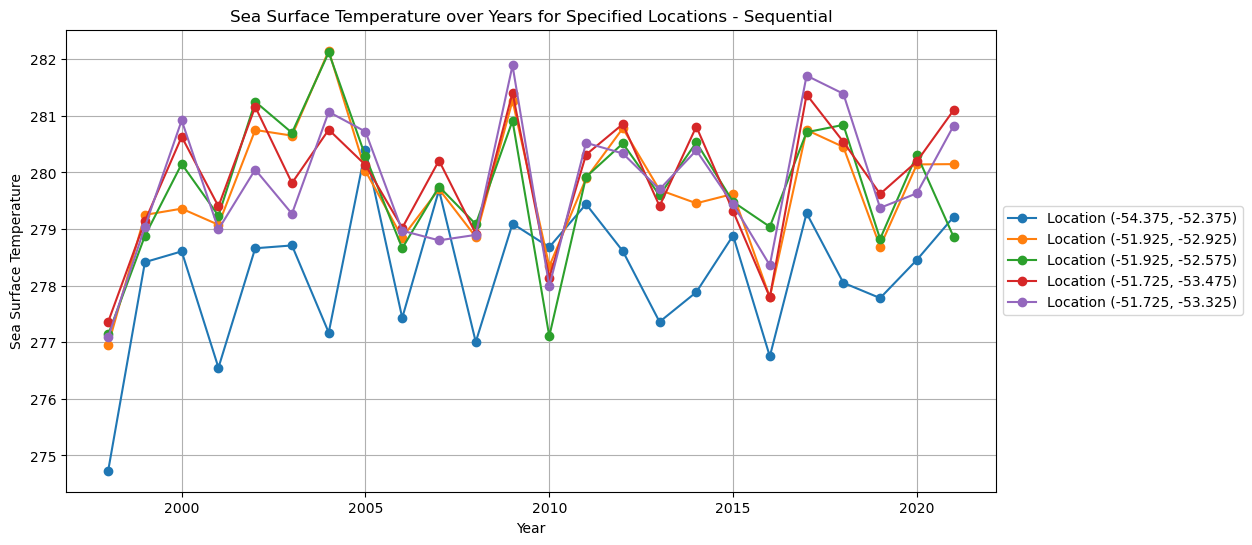

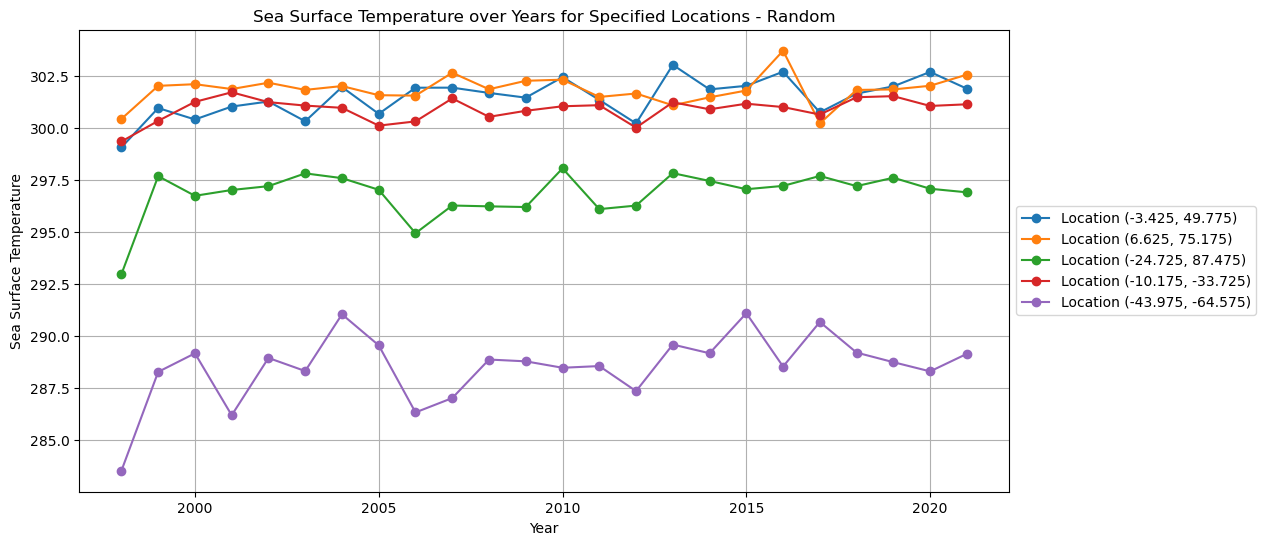

In [17]:
location_ids = list(filtered_grouped.index)

sequential_location_ids = location_ids[:5]
plot_sea_surface_temperature(sequential_location_ids, temp_time_series, "Sequential")

random_location_ids = random.sample(location_ids, 5)
plot_sea_surface_temperature(random_location_ids, temp_time_series, "Random")

### Constructing the Network

In [24]:
time_series_dict = temp_time_series.groupby('location_id')['Sea_Surface_Temperature'].apply(list).to_dict()
location_ids = list(time_series_dict.keys())

#### Mutual Information

Mutual information (MI) is the excess amount of information generated by falsely assuming the two time series $a_i$ and $a_j$ to be independent [1].

Mutual information between two distributions is the amount that one distribution's information (or differential entropy) is decreased by knowing the other's distribution [2].

$$
M_{ij} = \sum_{\mu \nu} p_{ij}(\mu, \nu) \log \frac{p_{ij}(\mu, \nu)}{p_i(\mu)p_j(\nu)},
$$

- $p_i(\mu)$ is the probability density function (PDF) of the time series $a_i$ 
- $p_{ij}(\mu, \nu)$ is the joint PDF of a pair $(a_i, a_j)$ 

Calculating the mutual information between each pair of locations.

In [80]:
mi_matrix = np.zeros((len(location_ids), len(location_ids)))
for i, loc1 in enumerate(location_ids):
    for j, loc2 in enumerate(location_ids):
        if i < j:
            mi = mutual_info_regression(np.array(time_series_dict[loc1]).reshape(-1, 1), 
                                        np.array(time_series_dict[loc2]))[0]
            mi_matrix[i, j] = mi
            mi_matrix[j, i] = mi

ValueError: Found input variables with inconsistent numbers of samples: [18, 19]

In [67]:
mi_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Calculating the Adjacency Matrix.

In [61]:
threshold = 1e-12
adjacency_matrix = (mi_matrix > threshold).astype(int)

In [68]:
adjacency_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

Creating the Network Graph

In [62]:
G = nx.from_numpy_array(adjacency_matrix)

In [63]:
G = nx.relabel_nodes(G, {i: location_ids[i] for i in range(len(location_ids))}) # relabeling nodes to match location_ids

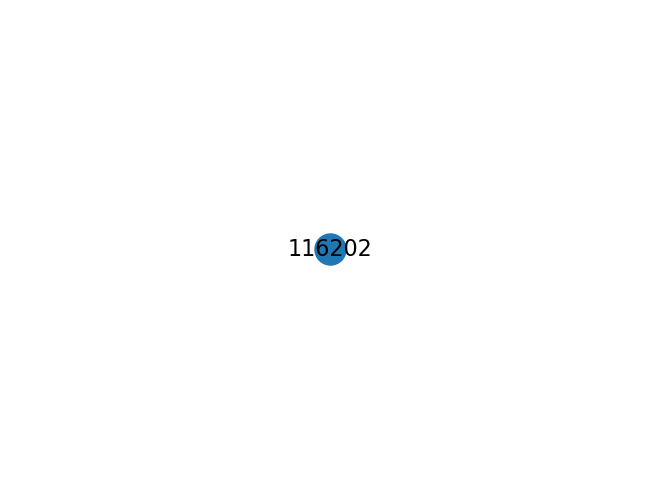

In [65]:
# Getting the largest connected component
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
Gc = G.subgraph(Gcc[0])

pos=nx.spring_layout(Gc)
nx.draw(Gc, with_labels = True, node_size=500, font_size=16, pos = pos)
plt.show(True)

In [ ]:


# Calculate betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)

# Identify communities using a community detection algorithm (e.g., Louvain)
from networkx.algorithms.community import louvain_communities

communities = louvain_communities(G)

# Print or analyze the results
print("Betweenness Centrality:", betweenness_centrality)
print("Communities:", communities)


### References

[1]
Donges, J. F., Zou, Y., Marwan, N., & Kurths, J. (2009). The backbone of the climate network. Europhysics Letters, 87(4), 48007. https://doi.org/10.1209/0295-5075/87/48007

[2]
Albers DJ, Hripcsak G. Estimation of time-delayed mutual information and bias for irregularly and sparsely sampled time-series. Chaos Solitons Fractals. 2012 Jun 1;45(6):853-860. doi: 10.1016/j.chaos.2012.03.003. PMID: 22536009; PMCID: PMC3332129.

# Network analysis reveals strongly localized impacts of El Niño

https://www.pnas.org/doi/abs/10.1073/pnas.1701214114

01/23/2017

### Abstract

Using network theory, we construct directed and weighted climate networks based on **near-surface air temperature** to study the global impacts of El Niño and La Niña. 

The constructed climate network enables the identification of the regions that are most drastically affected by specific El Niño/La Niña events. Our analysis indicates that the effect of the El Niño basin on worldwide regions is more localized and stronger during El Niño events compared with normal times.

Regions that are characterized by <span style="color:yellow">higher positive</span>/negative <span style="color:yellow">network in-weighted links are exhibiting stronger correlations with the El Niño basin and are warmer</span>/cooler <span style="color:yellow">during El Niño</span>/La Niña <span style="color:yellow">periods</span>. In contrast to non-El Niño periods, <span style="color:yellow">these stronger in-weighted activities are found to be concentrated in very localized areas</span>, whereas a large fraction of the globe is not influenced by the events. The regions of localized activity vary from one El Niño (La Niña) event to another; still, some El Niño (La Niña) events are more similar to each other. We quantify this similarity using network community structure. 

The results and methodology reported here may be used to improve the understanding and prediction of El Niño/La Niña events and also may be applied in the investigation of other climate variables.



### Introduction

#### Climate Networks

In recent years, network theory has been implemented in climate sciences to construct climate networks. These networks have been used successfully to analyze, model, understand, and even predict climate phenomena.

A network is composed of nodes and links; in a climate network, <span style="color:yellow">the nodes are the geographical locations, and the links are the correlations between them</span>. The strength of the links is quantified according to the strength of the correlations between the different nodes.

#### El Niño

El Niño refers to the warming of the central and eastern equatorial Pacific Ocean by several degrees. La Niña is the cooling of sea surface temperatures (SSTs) in the eastern tropical Pacific Ocean. La Niña usually follows an El Niño event, but not always; the overall phenomenon is referred to as El Niño-Southern Oscillation (ENSO). This cycle occurs every 3–5 years with different magnitudes. 

There are several indices that quantify the El Niño activity, including the Niño 3.4 Index, the Southern Oscillation Index (SOI), and the Oceanic Niño Index (ONI), which is the National Oceanic and Atmospheric Administration’s (NOAA) primary indicator for monitoring El Niño and La Niña. ONI is the running 3-month mean SST anomaly for the Niño 3.4 region:
- Northern boundary: 5°N
- Southern boundary: 5°S
- Western boundary: 170°W
- Eastern boundary: 120°W

We refer to this region as the El Niño Basin (ENB).

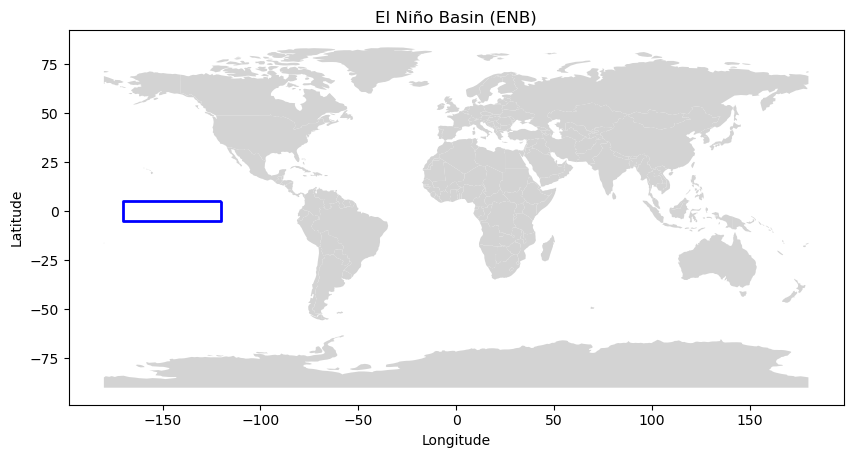

In [8]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

polygon_coords = [
    (-120, 5),
    (-170, 5),
    (-170, -5),
    (-120, -5),
    (-120, 5)
]

polygon = Polygon(polygon_coords)

gdf = gpd.GeoDataFrame(index=[0], crs="EPSG:4326", geometry=[polygon])

fig, ax = plt.subplots(figsize=(10, 5))
gdf.boundary.plot(ax=ax, color='blue', linewidth=2)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax, color='lightgrey')

ax.set_title('El Niño Basin (ENB)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()


When $\textcolor{yellow}{\text{ONI} > 0.5^\circ\text{C}}$ for at least five consecutive months, the corresponding year is considered to be an <span style="color:yellow;">El Niño</span> year. The higher the ONI is, the stronger the El Niño.

Similarly, La Niña is determined to occur when $\text{ONI} > -0.5^\circ\text{C}$ for at least five consecutive months. 

The El Niño phenomenon strongly affects human life. It can lead to warming, enhanced rain in some regions and droughts in other regions, decline in fishery, famine, plagues, and economic changes through globally networked system.

#### Findings

We construct the climate network by using only directed <span style="color:green;">links from the ENB to regions outside the ENB</span> (which we call here <span style="color:green;">in-links</span>). The constructed in-weighted climate network enables us not only to obtain a map of the global impacts of a given El Niño event, but also to study the impacts of El Niño in specific regions.

We identify warming and cooling regions that are influenced by the ENB by measuring each node’s strength according to the weights of its links coming from the ENB.

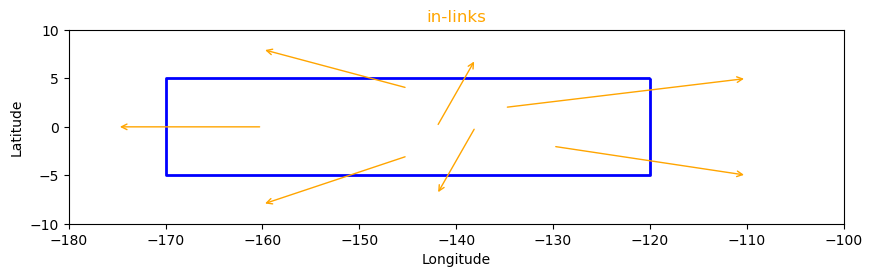

In [22]:
fig, ax = plt.subplots(figsize=(10, 5))
world.plot(ax=ax, color='lightgrey')
gdf.boundary.plot(ax=ax, color='blue', linewidth=2)
ax.set_xlim(-180, -100)
ax.set_ylim(-10, 10)
ax.set_title('in-links', color='orange')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

arrowprops = dict(facecolor='orange', edgecolor='orange', arrowstyle="->")

arrows = [
    {'start': (-135, 2), 'end': (-110, 5)},
    {'start': (-145, 4), 'end': (-160, 8)},
    {'start': (-130, -2), 'end': (-110, -5)},
    {'start': (-160, 0), 'end': (-175, 0)},
    {'start': (-145, -3), 'end': (-160, -8)},
    {'start': (-142, 0), 'end': (-138, 7)},
    {'start': (-138, 0), 'end': (-142, -7)}
]


for arrow in arrows:
    ax.annotate('', xy=arrow['end'], xytext=arrow['start'], arrowprops=arrowprops)

plt.show()


During El Niño/La Niña, a large fraction of the globe is not influenced by the events, but the regions that are influenced are significantly more affected by the ENB than in normal years. The climate structure becomes well-confined in certain localized regions during a fully developed El Niño event. This phenomenon is evident by inspecting the emergent teleconnections between the ENB and localized regions. Such a large-scale cooperative mode helps us to forecast El Niño events.

The El Niño/La Niña events influence different regions with different magnitudes during different events; still, <span style="color:yellow;">by determining the network community structure</span>, our results suggest that similarities exist among some of the El Niño (La Niña) events.

The impact of El Niño is very variable and that it is localized and strong during El Niño events; we quantify this variability and the intensity effect and found, using a directed and weighted network, that it is strongly related to El Niño.

### Methodology

Our evolving climate network is constructed from the global daily near-surface (1000 hPa) air temperature fields of the National Center for Environmental Prediction/National Center for Atmospheric Research (NCEP/NCAR). 

The spatial (zonal and meridional) resolution of the data are $2.5^\circ \times 2.5^\circ$, resulting in $144 \times 73 = 10512$ grid points. 

The dataset spans the time period between January 1948 and April 2016. Because for each window $365 + 200$ days’ daily data are used, and the newest data we can obtain is until May 6, 2016, so $\Phi^y$ is terminated at the 11th window of 2014. 

To avoid the strong effect of seasonality, we subtract the mean seasonal cycle and divide by the seasonal SD for each grid point time series. 

The overall analysis is based on a sequence of networks, each constructed from time series that span 1 year.


The nodes (grid points) are divided into <span style="color:yellow;">two subsets</span>. One subset includes the <span style="color:yellow;">nodes within the ENB</span> ($57$ nodes) and the other the <span style="color:yellow;">nodes outside the ENB</span> ($10455$ nodes). For each pair of nodes, $\textcolor{yellow}{i}$ and $\textcolor{yellow}{j}$, each from a different subset, respectively, the cross-correlation between the two time series of 365 days is calculated,

$$
C_{i,j}^{y}(\tau) = \frac{\langle T_i(d) T_j(d - \tau) \rangle - \langle T_i(d) \rangle \langle T_j(d - \tau) \rangle}{\sigma_{T_i(d)} \sigma_{T_j(d - \tau)}}
$$



- $C_{i,j}^y$: cross-correlation between the time series of 365 days associated with $i$ and with $j$.
- $\sigma_{T_i(d)}$ is the standard deviation (SD) of $T_i(d)$.
- $\tau \in [0, \tau_{\text{max}}]$ is the time lag, with $\tau_{\text{max}} = 200$ days.
- $y$ indicates the starting date of the time series with 0 time shift.
- $T$: temperature ???
- $d$: day

$C_{i,j}^{y}(-\tau) \equiv C_{j,i}^{y}(\tau)$.

We then identify the value of the highest peak of the absolute value of the cross-correlation function and denote the corresponding time lag of this peak as $\theta_{i,j}^{y}$. 

- $\theta_{i,j}^{y}$: time lag of the peak.

The sign of $\theta_{i,j}^{y}$ indicates the direction of each link:
  - $\theta_{i,j}^{y} > 0 \implies$ the direction of the link is from $i$ to $j$.
  - $\theta_{i,j}^{y} < 0 \implies$ the direction of the link is from $j$ to $i$.


 Below, we focus on the overall effect of the ENB on grid points outside this region and thus refer to the links directed from the ENB to a grid point $j$ as in-links to grid point $j$.

 We only consider in-links with time lag shorter than 5 months: 
 
 $\left| \theta_{i,j}^{y} \right| \leq 150 \, \text{d}$

as we focus on the influence of El Niño on the rest of the world on seasonal time scales.

The figure below shows examples of in-links over different regions.

<img src="figs/fig1.jpeg" alt="Network Analysis Diagram"/>

The link weights are determined by using $C_{i,j}^{y}(\theta)$, and we define the strength of the link as

$$
W_{i,j}^{y} = \frac{C_{i,j}^{y}(\theta) - \text{mean}(C_{i,j}^{y}(\tau))}{\text{std}(C_{i,j}^{y}(\tau))},
$$

- $W_{i,j}$: strength of the $i$-$j$ link.


We construct networks based on both $C_{i,j}(\theta)$ and $W_{i,j}$, and these are consistent with each other.

The adjacency matrix of a climate network is defined as

$$A_{i,j}^{y} = (1 - \delta_{i,j})H(\theta_{i,j}^{y})$$

- Heaviside step function 
$
H(x) :=
\begin{cases} 
1, & \text{if } x \geq 0 \\
0, & \text{if } x < 0 
\end{cases}
$

- $I_{i}^{y}$: in-degree of the node $i$ (number of links into the node).
$$I_{i}^{y} = \sum_{j}A_{j,i}^y$$
- $O_{i}^{y}$: out-degree of node $i$ (number of links out from the node).
$$O_{i}^{y} = \sum_{j}A_{i,j}^y$$

We define the total in-weights of each node outside the ENB as the sum of the weights of its in-links, using $C_{j,i}^{y}$ and $W_{j,i}^{y}$:

$$\text{IN}(C_{i}^{y}) = \sum_{j \in \text{ENB}}A_{j,i}^{y}C_{j,i}^{y}(\theta),$$

$$\text{IN}(W_{i}^{y}) = \sum_{j \in \text{ENB}}A_{j,i}^{y}W_{j,i}^{y}$$


Larger positive values of $\text{IN}(C_{i}^{y})$ and $\text{IN}(W_{i}^{y})$ reflect stronger warming due to the impact of the ENB.

Smaller negative values of $\text{IN}(C_{i}^{y})$ and $\text{IN}(W_{i}^{y})$ reflect weaker cooling due to the impact of the ENB.

If there are no in-links for a node, both the in-degree and in-weights are zero, indicating no impact of the ENB.

Based on the ONI, we divide the 68 record years into El Niño, La Niña, and normal years. For simplicity, we only consider moderate and strong El Niño/La Niña events with $\text{ONI} > -1^\circ\text{C}$. For each event, we consider the time series from July 1 preceding the event to June 30 of the next year, to cover the whole range of one El Niño/La Niña period. The year is centered on the Northern Hemisphere winter, such that, for example, the year labeled 1980 runs from July 1, 1980 to June 30, 1981.

Based on this definition, we consider 11 El Niño and 9 La Niña events between the years of 1948 and 2015. 

We calculate the in-weighted degree fields for El Niño and La Niña by taking the average of the same type of events using

$$\text{IN}(C_i) = \sum_{y \in EY (LY)} \frac{\text{IN}(C_i^y)}{S}$$

$$\text{IN}(W_i) = \sum_{y \in EY (LY)} \frac{\text{IN}(W_i^y)}{S},$$

where 

$$S = \sum_{y \in EY (LY)} I_i^y,$$

$EY$: years in which the El Niño occurs.

$LY$: years in which the La Niña occurs.


Regions affected by El Niño/La Niña, either by warming or cooling, are charcterized by relatively <span style="color:yellow;">high in-weights</span> and by temperature anomalies.

<img src="figs/fig1.jpeg" alt="Network Analysis Diagram" style="width:50%;"/>

The maps of temperature anomalies are obtained by first calculating a 3-mo (December–February) mean temperature anomaly for each year, and then taking an average of the mean value over all El Niño/La Niña years. The El Niño/La Niña-related in-weighted extent fields are hemispherically symmetric, to some degree.

### Results

In the table below, we compare the in-weighted degree maps of El Niño/La Niña events with the corresponding temperature anomaly maps by evaluating the cross-correlation between each pair of maps shown in the figure above. 

| R                                 | El Niño | La Niña |
|-----------------------------------|---------|---------|
| $R_{\text{IN}(C), T}$             | 0.59    | -0.55   |
| $R_{\text{IN}(W), T}$             | 0.54    | -0.51   |
| $R_{\text{IN}(W), \text{IN}(C)}$  | 0.92    | 0.95    |

$$
R = \frac{
\sum_{i=1}^{N} (C_i - \langle C \rangle)(T_i - \langle T \rangle) \cos(\lambda_i)
}{
\sqrt{\sum_{i=1}^{N} (C_i - \langle C \rangle)^2 \cos(\lambda_i)} \sqrt{\sum_{i=1}^{N} (T_i - \langle T \rangle)^2 \cos(\lambda_i)}
}
$$


$$
\langle C \rangle = \frac{\sum_{i=1}^{N} C_i \cos(\lambda_i)}{\sum_{i=1}^{N} \cos(\lambda_i)}
$$
$$
\langle T \rangle = \frac{\sum_{i=1}^{N} T_i \cos(\lambda_i)}{\sum_{i=1}^{N} \cos(\lambda_i)}
$$

- $i$: Labels of the nodes taken into consideration.
- $\langle \cdot \rangle$: Indicates the average over all the nodes.
- $C_i$: "In"-weights of node $i$.
- $T_i$: Temperature anomaly of node $i$.
- $\lambda_i$: Latitude of node $i$.


During El Niño/La Niña events, the overall global area that is influenced by the ENB becomes smaller, whereas the impacts in these more limited areas become stronger. This enhanced impact in localized regions is demonstrated in the figure below, which compares the global distributions of the
- in-degrees $\text{IN}(N)$
- in-weights $\text{IN}(W)$
- $\text{IN}(C)$

of typical El Niño and normal years.

<img src="figs/fig2.jpeg">
<span style="color:gray;">The in-degree fields (N, W, and C) in a typical El Niño event, 1972 (A, C, and E), and a normal year, 1959 (B, D, and F).</span>

A quantitative analysis of the area (number of nodes) that is affected/unaffected during El Niño and La Niña years is shown in the figure below where El Niño and La Niña years are, respectively, emphasized by the red and blue shading. 

<img src="figs/fig3.jpeg">

The 3-months running average of $N^y$ and $C^y$. (A) The ONI as a function of time. (B) The evolution of the number of nodes that have in-links with time (number of nodes with zero in-degree $N^y$ as a function of time). (C) The evolution of the average in-weights per node with time.

The temporal evolution of the climate network is studied by constructing a sequence of networks based on successive windows of lengths of $365 + 200d$, with a beginning date that is shifted by 1 month each time.

We focus on El Niño (La Niña) events with ONIs that are larger (smaller) than $1^\circ\text{C} (-1^\circ\text{C})$.

The average in-weights per node (fig C), are given by dividing the sum of the absolute weights of all in-links of each node outside the ENB by $N^y$:

$$C^y = \sum_{i \notin \text{ENB}} \sum_{j \in \text{ENB}} \frac{A_{j,i}^y |C_{j,i}^y(\theta)|}{N^y}$$


During El Niño/La Niña, the number of nodes with no in-links, $N^y$, drops dramatically (fig B), indicating that the total area influenced by the ENB is much smaller.

Moreover, during El Niño/La Niña, $C^y$ increases significantly, indicating a stronger impact of the ENB in the areas that are influenced by it. We chose the 1982–1983 El Niño event to depict the evolution of ENSO impact, from its onset to its decay.

Plotting the in-weights maps every 3 months, we have the evolution of the ENSO impact for a special El Niño event (1982) from onset to withdrawal:
<img src="figs/fig4.png">

During the El-Niño event, the links are more localized in comparison with the beginning and the end of the event. To quantify the significance of the results, we used a randomization procedure in which we shuffled the years of each node’s time series (keeping the time ordering within each year unchanged) and then constructed the in-weighted networks.

We found that $C^y \ge 8$ and $N^y \ge 6300$ are significant with $p$ values $< 10^{-3}$.

The success of the climate-network-based measures to detect the El Niño/La Niña events strengthens the reliability of this approach in studying climate phenomenon.

It is possible to classify El Niño events based on the location of their maximum SST anomalies and on their tropical midlatitude teleconnections. Here, we propose <span style="color:yellow;">classifying different types of El Niño events based on the similarity between them</span>, which can be determined by the <span style="color:yellow;">cross-correlations between pairs of maps</span>. 

We determine the significance of the cross-correlation using shuffled network maps. The shuffling is performed by dividing the map (globe) into 18 equal areas, shuffling their spatial orders for each event, and then evaluating the cross-correlation between each pair of the shuffled global network maps. Eventually, we obtain a distribution of the cross-correlation values through the shuffling process. Only correlations with $p$ values $< 0.01$ are considered as significant.

The cross-correlations between pairs of El Niño events is shown in the figure below.

<img src="figs/fig5.jpeg"/>

It shows the community structure of the 11 l Niño events. (A–D) The heat map of cross-correlations between pairs of El Niño events, based on the global (A), tropical (B), Northern Hemisphere (C), and Southern Hemisphere (D) maps of the in-weighted climate network. (E) Community structure in the network of 11 El Niño events. Different colors represent different communities.

Insignificant cross-correlation is indicated by the white color. Fig B-D show the heatmaps of cross-correlations for the different regions.

Based on this heat map, the 11 El Niño events are divided into three groups with extended white areas separating them, indicating that El Niño events within the same group tend to have similar global impact patterns. Furthermore, we divide the globe into three regions, approximately equal in area: "Tropics" (20°S to 20°N), "North" (20°N to 90°N), and "South" (20°S to 90°S). Then, separately for each region, we calculate the cross-correlations between the map pairs of the in-weighted climate network. The significant cross-correlations are also determined by $p$ values $<0.01$, by shuffling the spatial orders of nodes within the same regions. 

We find that the global similarity structure receives different contributions from different regions. More specifically, the heat map for the Tropics region (fig B) is much more similar to the heat map for the global area (fig A), in comparison with the other two regions, indicating that the impact of El Niño in the tropics dominates the classification of El Niño events. 

We also construct the matrix of similarity of El Niño events based on the mean winter temperature anomaly and find that it is consistent with the network-based similarity structure.

<img src="figs/fig6.png"/>

The community structure of 11 El Niño events.

(a) The heat map of cross-correlations between pairs of El Niño events, based on the global maps of the "in"-weighted climate network. Here, only significant values with p-values no larger than 0.01 are included.

(b) The heat map of normalized scalar products between pairs of El Niño events, based on the global maps of the mean winter temperature anomaly. Here, only significant values with p-values no larger than 0.05 are included.

(c) The heat map of cross-correlations between pairs of El Niño events, based on the global maps of the "in"-weighted climate network. Here, only pairs of years that are significantly similar in both the network structure and the temperature are included.

(d) The heat map of normalized scalar products between pairs of El Niño events, based on the global maps of the mean winter temperature anomaly. Here, only pairs of years that are significantly similar in both the network structure and the temperature are included.


A weighted network of the 11 El Niño years is also constructed based on the significant correlations given in the figure fig A is shown in fig E. The thickness of each link represents the correlation value between the two connected years.

<img src="figs/fig5.jpeg" style="width:50%;"/>

Then, by using a modularity optimization heuristic algorithm , our network is subdivided into three communities, which is consistent with the groups in fig A. 

To view the correlation patterns associated with each of the three communities, we chose three representative El Niño years (2009, 1986, and 1957), each from a different community. The in-weight maps are shown below.

<img src="figs/fig7.png"/>

The correlation patterns are quite different from each other; the correlation coefficients between them are summarized in the figure GLOBAL fig A.



A general pattern of El Niño/La Niña’s global impacts, as well as of their dynamical evolutions, are obtained from a time-evolving in-weighted climate network. By averaging the in-weighted degree fields of all significant El Niño/La Niña events, we identify the regions that tend to be more influenced by those events. One of the most important results of our study is that, during El Niño/La Niña periods, a smaller world area is affected by the ENB, but the impact of El Niño/La Niña is enhanced in these more localized regions. This observation is rooted in the fact that, during El Niño/La Niña, the entire ENB warms/cools; in addition, the regions that become warmer/cooler have similar/opposite tendencies with respect to the ENB. These synchronized behaviors enhance the overall correlation of the ENB with the rest of the world. However, during normal periods, part of the ENB is correlated and part is not, thus reducing the overall correlation and extending the regions of correlation.

The method proposed above enables the detection of local effects of each El Niño event.

Evidently, these enhanced and localized El Niño effects are associated with serious consequences in many aspects of human life.

The method we propose here enables the detection of the above regions as well as other regions across the globe that are affected by ENSO.

<img src="figs/fig8.png"/>

The cross-correlation function for three “in”-link examples from the ENB (which are mentioned in Fig. 1 (a) and (b)).

(a) From the ENB to Chicualacuala in Mozambique during the 2009-2010 El Niño event.

(b) From the ENB to Rambaxpura in India during the 2002-2003 El Niño event.

(c) From the ENB to Jundah in Australia during the 2010-2011 La Niña event.


The regions affected by El Niño vary from one El Niño event to another, making it difficult to predict the impacts of an upcoming El Niño. However, it is still possible to evaluate for each region (grid point) the probability to be affected by ENB by using our climate network approach. 

We define the frequency $P_i$ for each node $i$ in which the in-degrees $I_i^y$ are nonzero. This $P_i$ quantifies the probability effected by ENB.


The figure below shows the spatial distribution of frequency $P_i$ for each node $i$. The regions marked by red color have high probability (at least $\frac{10}{11}$) effected by El Niño. It is the spatial distribution of $P_i \ge 10$ (among 11 El Niño events); thse regions are marked by red color (indicating probability $>> 90$%)

<img src="figs/fig9.png"/>

El Niño phenomena can lead to warming or cooling in some regions, and the warming or cooling can be quantified by using $\text{IN}(C_i^y)$-positive values for warming effects and negative values for cooling effects.

- fig A shows the spatial distribution of positive $\text{IN}(C_i^y)$ frequency.
- fig B shows the spatial distribution of negative $\text{IN}(C_i^y)$ frequency.

<img src="figs/fig10.png"/>

The frequency for the temperature anomalies are above 1 standard deviation (fig C) and below -1 standard deviation (fig D) of normal years

We find that some regions, such as Western North American, Western South America, South Indian, South Africa, and South Pacific, are very frequently and positively (warming) affected by El Niño; yet some regions, such as Southern South America and North Asian, are very frequently and negatively (cooling) affected.

These results are consistent to some degree with the temperature anomalies during El Niño  (fig 1 E - Temperature Anomalies).

To strengthen the above results, we also analyzed the frequency (during El Niño years) of the temperature anomalies to be above (fig C) or below (fig D) one SD of normal years.

These results support the results obtained by using the network approach and can help to identify the regions that have the highest probability to be affected by El Niño.

### Conclusion

Finally, according to our results, different El Niño events can drive different extreme weather conditions in different regions. For instance, the recently terminated El Niño event was distinct from most El Niño events in certain key aspects of climate disruptions. Collecting updated information is important in improving related models. Meanwhile, the detection of similarities between different El Niño events is also helpful in understanding important common aspects. We distinguish between different types of El Niño events based on the similarities between the networks of these events. 

According to our results, the similarities between different events are mostly due to the impacts of El Niño on Tropics (20°S to 20°N) compared with North (20°N to 90°N) and South (20°S to 90°S); the Tropics area is ~1/3 of the global world area. The methodology and results presented here may help to improve the understanding of the impacts of ENSO, and hopefully to provide the ability, in the future, to take early actions to reduce the damage caused by El Niño. The mechanism underlying the results reported above is still not clear to us, and further study, maybe related to teleconnections, is needed to explore this mechanism.


# The Backbone of the Climate Network

https://iopscience.iop.org/article/10.1209/0295-5075/87/48007/pdf

09/08/2009

### Abstract

We propose a method to reconstruct and analyze a complex network from <span style="color:yellow">data generated by a spatio-temporal dynamical system</span>, relying on the nonlinear mutual information of time series analysis and betweenness centrality of the complex network theory.

This approach reveals a rich internal structure in complex climate networks constructed from reanalysis and model surface air temperature data.

Our novel method uncovers peculiar <span style="color:yellow">wave-like structures of high-energy flow</span>, that we relate to <span style="color:yellow">global surface ocean currents</span>.

This points to a major role of the oceanic surface circulation in coupling and stabilizing the global temperature field in the long-term mean (140 years for the model run and 60 years for reanalysis data). 

### Introduction

The **<span style="color:green">vertices</span>** of a climate network are identified with the <span style="color:green">spatial grid points</span> of an underlying global climate data set. 

**<span style="color:green">Edges</span>** are added between pairs of vertices depending on the <span style="color:green">degree of statistical interdependence between the corresponding pairs of anomaly time series</span> taken from the climate data set.

Climate networks enable novel insights into the topology and dynamics of the climate system over many spatial scales ranging from local properties as the number of first neighbors of a vertex $v$ (the _degree centrality_ $k_v$) to global network measures such as the _clustering coefficient_ or the _average path length_.

<span style="background-color:#006400;">The local degree centrality and related measures have been used to identify supernodes (regions of high degree centrality) and to associate them to known dynamical interrelations in the atmosphere, called teleconnection patterns</span>, most notably the North Atlantic Oscillation (NAO).

On the global scale, climate networks were found to possess **small-world** properties due to <span style="background-color:brown">long-range connections (edges linking geographically very distant vertices)</span> that stabilize the climate system and enhance the energy and information transfer within it.

<span style="background-color: brown;">By studying the prevalence of long-range connections in El Niño and La Niña climate networks and the time dependence of the number of stable edges, it has been shown very recently that the El Niño-Southern Oscillation (ENSO) has a strong impact on the stability of the climate system.</span>


Until now, researchers have used the _<span style="color:gray">linear cross-correlation</span>_ function of pairs of anomaly time series to <u>quantify the degree of statistical interdependence between different spatial regions</u >. But the highly nonlinear processes at work in the climate system call for the application of *nonlinear* methods to obtain more reliable results. 

Here we also use <span style="color:orange">mutual information</span> to construct climate networks allowing to <u>capture linear and nonlinear relationships between time series</u>. Furthermore we use a measure of vertex centrality, <span style="color:orange">betweenness (BC)</span>, that is defined locally but takes into account global topological information. 

Combining these two techniques, we uncover peculiar <span style="background-color:brown">wave-like structures in the BC fields of climate networks</span> constructed from monthly averaged reanalysis and atmosphere-ocean coupled general circulation model (AOGCM) surface air temperature (SAT) data. Akin to the homonymous data highways of the internet, <span style="color:yellow">these BC structures form the backbone of the SAT network</span>, bundling most of the energy flow between remote regions.

Some major features of the <span style="color:yellow">backbone</span> appear to be closely related to surface ocean currents pointing to an essential <span style="color:yellow">role of the oceanic surface circulation in stabilizing the climate system by promoting the global flow of energy</span>, mainly in the form of heat.

These insights are conceptually new and cannot be obtained using classical methods of climatology such as principal component analysis (PCA) or singular spectrum analysis (SSA) of anomaly fields, because these are by design local in a network sense and are not suitable to study local flow measures depending on a global network topology.


The methodology developed in this letter has the potential to be universally applicable to extract the energy, matter or information flow structure in any spatially extended dynamical system from observations taken from the real world, experiments and simulations.

### Data

We utilize the monthly averaged global SAT field to construct climate networks, that allows to directly capture the complex dynamics on the interface between ocean and atmosphere due to heat exchange and other local processes.

SAT therefore enables us to study atmospheric as well as oceanic dynamics using the same climate network. 

We use reanalysis data provided by the National Center for Environmental Prediction/National Center for Atmospheric Research (NCEP/NCAR) and model output from the World Climate Research Programme’s (WCRP’s) Coupled Model Intercomparison Project phase 3 (CMIP3) multimodel data set. For optimal comparability with the reanalysis data, we choose a 20th century reference run (20c3m, as defined in the IPCC AR4) by the Hadley Centre HadCM3 model.


##### Reanalysis Data
- **Definition**: Reanalysis data is a combination of historical observational data and numerical weather prediction models. It's essentially a retrospective analysis of past weather data, where historical observations are integrated with modern models to produce a consistent and comprehensive dataset.
- **NCEP/NCAR Reanalysis**: This is a well-known reanalysis dataset provided by the National Center for Environmental Prediction (NCEP) and the National Center for Atmospheric Research (NCAR). It covers global weather data and is often used for climate studies.

#### Model Output
- **Definition**: Model output refers to data generated from climate models, which are simulations of the Earth's climate system based on various physical principles and equations.
- **CMIP3 Multimodel Data Set**: This dataset is part of the World Climate Research Programme’s (WCRP) Coupled Model Intercomparison Project phase 3 (CMIP3). It involves multiple climate models from different research institutions worldwide, used for comparing and understanding climate projections.
- **HadCM3 Model**: The Hadley Centre Coupled Model, version 3 (HadCM3), is one of the models included in the CMIP3 dataset. It is developed by the Hadley Centre and is widely used for climate simulation and projection.

#### Specifics in the Article
- **Comparability**: To ensure that the model output is comparable with the reanalysis data, the authors use a specific simulation from the HadCM3 model called the "20th century reference run (20c3m)." This simulation is designed to replicate climate conditions from the 20th century based on historical data and is defined by the Intergovernmental Panel on Climate Change (IPCC) in its Fourth Assessment Report (AR4).
  
The aim is to study and compare historical climate data with simulated climate conditions.

A data set consists of a regular spatio-temporal grid with time series $x_i(t)$ associated to every spatial grid point $i$ at latitude $\lambda_i$ and longitude $\phi_i$. Start and end dates, length of time series $\tau$, latitudinal resolution $\Delta\lambda$, longitudinal resolution $\Delta\phi$ and the number of vertices of the corresponding global climate network $N$ are given in the table below.

- $x_i(t)$: time series
- $i$: grid point
- $\lambda_i$: grid point latitude
- $\phi_i$: grid point longitude
- $\tau$: length of the time series, in months
- $\Delta\lambda$: latitudinal resolution


|               | NCEP/NCAR         | HadCM3           |
|---------------|--------------------|------------------|
| Period   | 01/1948–12/2007    | 01/1860–12/1999  |
| $\tau$ (months)  | 720                | 1680             |
| $\Delta\lambda$ (°) | 2.5                | 2.5              |
| $\Delta\phi$ (°) | 2.5                | 3.75             |
| $N$         | 10224              | 6816             |



### Methodology

To minimize the bias introduced by the external solar forcing common to all time series in the data set, we calculate anomaly time series $a_i(t)$ from the $x_i(t)$ (removes the mean annual cycle by phase averaging). Using only data from a particular season to avoid biases due to this effect does not alter our results substantially, so that we choose to use the whole data set for a more accurate evaluation of interdependence. Furthermore we normalize the anomaly time series to zero mean and unit variance.

Mutual information (MI) is a measure from information theory, that can be interpreted as the excess amount of information generated by falsely assuming the two time series $a_i$ and $a_j$ to be independent, and is able to detect linear as well as nonlinear relationships. MI can be estimated using

$$
M_{ij} = \sum_{\mu \nu} p_{ij}(\mu, \nu) \log \frac{p_{ij}(\mu, \nu)}{p_i(\mu)p_j(\nu)},
$$

where 
- $p_i(\mu)$ is the probability density function (PDF) of the time series $a_i$ 
- $p_{ij}(\mu, \nu)$ is the joint PDF of a pair $(a_i, a_j)$ 

By definition, $M_{ij}$ is symmetric, so that $M_{ij} = M_{ji}$. Note that in principle, one can evaluate a time delayed MI. This is appropriate when studying climate networks on smaller time scales using data sets with (sub-)diurnal resolution. However, in the present work, we intend to study long-term structural properties of the climate system on a scale of $O(10^2)$ years using monthly averaged data. Most physical mechanisms of global information transfer in the SAT field such as travelling Rossby waves, heat exchange between ocean and atmosphere or the advection of heat by surface currents in the ocean act at time scales of less than one month. Therefore, it is reasonable to calculate MI at zero lag between anomaly time series.

We now construct the climate network by thresholding the MI matrix $M_{ij}$, i.e., only pairs of vertices $(i, j)$ that satisfy $M_{ij} > \tau$ are regarded as linked, where $\tau$ is the threshold. Using the Heaviside function $\Theta(x)$, the adjacency matrix $A_{ij}$ of the climate network is given by 

$$ A_{ij} = \Theta(M_{ij} - \tau) - \delta_{ij} $$

where $\delta_{ij}$ is the Kronecker delta. 

$$
\delta_{ij} = 
\begin{cases} 
1 & \text{if } i = j \\
0 & \text{if } i \neq j 
\end{cases}
$$

Note that $A_{ij}$ inherits its symmetry from $M_{ij}$ and the resulting climate network is an undirected and unweighted simple graph. One could construct a network with edges $(i, j)$ weighted by $M_{i,j}$.

We find that network characteristics, such as BC, clustering coefficient, and average path length, are dependent on the choice of the threshold $\tau$. When comparing climate networks constructed from AOGCM and reanalysis data, it is consequently more meaningful to constrain the edge density $\rho = \frac{2E}{N(N-1)}$, where $E$ gives the total number of edges, than to fix $\tau$ as it was done in all earlier works. The threshold $\tau = \tau(\rho)$ is thus chosen to yield a prescribed edge density $\rho$. The PDF of MI $P(M)$ over all pairs $M_{ij}$ is found to have a connected support, so that the edge density function $\rho(\tau) = \int_{\tau}^{\infty} dMP(M)$ is strictly monotonic decreasing with $\tau$ and induces a one-to-one correspondence between $\tau$ and $\rho$. Note that the backbone of the climate network is most clearly observed at small $\rho$ with corresponding large threshold $\tau$, that is very unlikely to be exceeded by chance, as we reassured using significance tests based on randomly shuffled time series, Fourier surrogates, and twin surrogates. We fix the edge density at $\rho = 0.005$, resulting in thresholds of $\tau_1 = 0.398$ for the HadCM3 data and $\tau_2 = 0.624$ for the reanalysis data. The remaining 0.5% of all possible edges correspond to statistically significant and robust relationships. In concordance with this observation, we find that small variations of $\rho$ from the chosen value do not alter the backbone structure significantly. The remaining edges are distributed heterogeneously as they attach preferentially to pronounced supernodes, their range extending from local to global (teleconnections), which is consistent with earlier works.



Having constructed a climate network, we can finally quantify the importance of a small part of the Earth's surface (represented by a single vertex $v$) for the global flow of energy within the SAT field, that gives rise to the pairwise dynamical interdependencies measured by MI. Vertices play distinct roles in the energy transmission throughout the network, some of them show a higher capability as compared to others. This capability can be quantified by the betweenness $BC_v$. Assume that energy travels through the network on shortest paths. We then regard a vertex $v$ to be important for the energy transport in the network, if it is traversed by a large number of all existing shortest paths. The betweenness centrality is defined as

$$
BC_v = \sum_{i,j \neq v} \frac{\sigma_{ij}(v)}{\sigma_{ij}}, \forall v \in (1, \ldots, N)
$$

where
- $\sigma_{ij}(v)$: number of shortest paths between vertices $i$ and $j$ that pass through $v$
- $\sigma_{ij}$: total number of shortest paths between $i$ and $j$

The contribution of shortest paths is weighted by their respective multiplicity $\sigma_{ij}$. Because the shortest paths considered contain only edges corresponding to pairs of highly dynamically interrelated time series, BC can be interpreted as a local measure of dynamical information flow. Since we use it to analyze a temperature field we nevertheless prefer to view BC more fundamentally as a measure of the flow of energy, mainly in the form of heat. BC is conceptually distinct from other commonly used vertex centrality measures, *e.g.*, degree and closeness centrality, and hence enables us to uncover interesting novel structural features of climate networks.


### Results

We uncover peculiar wave-like structures of high BC in fields of both reanalysis and model SAT climate networks.

<img src="figs/fig101a.png"/>
<img src="figs/fig101b.png"/>
<img src="figs/fig101c.png"/>

 a) BC for the NCEP/NCAR reanalysis SAT MI network.
 b) for the HadCM3 SAT network. Both networks are constructed at edge density $\rho = 0.005$ using MI. 
 c) A schematic map of global surface ocean currents. 
 
 Note that some features of the backbone in a) and b) correspond closely to ocean surface currents shown in c), *e.g.*, the Alaska, Peru, and Canary currents.

 In analogy with the internet, we call the network of these channels of high-energy flow the backbone of the climate network. We observe that prominent mainly meridional features of the backbone tend to approach the equator tangentially, as one would expect from modes of the atmospheric and oceanic general circulation due to the vanishing Coriolis force at the equator. There is also a qualitative agreement on the location of major backbone structures for both reanalysis (fig a) and model networks (fig b), *e.g.*, the high BC channel over the Atlantic Ocean and the backbone structures over the eastern Pacific Ocean, both connecting the Arctic with the Antarctic.



The BC field of the MI climate networks considered here shows qualitative and quantitative deviations when compared to climate networks constructed using the linear Pearson correlation (PC), while the backbone is clearly seen in both types of networks.

<img src="figs/fig102.png"/>

Normalized difference field 

$$\Delta BC_v = \frac{|BC_v^P - BC_v^M|}{\sqrt{\langle BC_w^P \rangle_w \langle BC_w^M \rangle_w}}$$

of BC fields $BC_v^P$ and $BC_v^M$, respectively calculated from PC and MI HadCM3 SAT climate networks at $\rho = 0.005$.

The observed deviations could be partly due to a heterogeneous distribution of Shannon entropy among the $a_i(t)$, introducing a bias in the calculation of $M_{ij}$. Also it is well known that the nonlinear features of temperature dynamics might vary among reanalysis data sets, among climate models as well as between reanalysis and model data sets. Nevertheless, we argue in [8], that some of the deviations in the BC field may be attributable to nonlinear physical processes in the climate system. Particularly, we find that edges corresponding to nonlinear statistical interrelationships are present in the MI climate network, which are excluded in the PC network at the same restrictive edge density level.

Note that the strongest backbone structures lie mainly over the ocean and avoid to cross the land in both model and reanalysis climate networks. Therefore, a physical mechanism involving an atmosphere-ocean coupling might contribute to the energy transport in the SAT field measured by BC. Some of the strongest features found in the NCEP/NCAR and HadCM3 BC fields (betweeness maps) resemble closely major surface ocean currents.

For example, note the strong BC structures off the west coast of North and South America that resemble the Alaska and Peru current, and the backbone feature along the west coasts of Africa and Europe following the path of the Canary and Norwegian currents.



These observations can be understood considering the strong coupling between sea surface temperature (SST) and SAT over the ocean via heat flux. Temperature anomalies in SST are advected by the surface ocean currents and transferred to the SAT field via heat flux coupling.

Therefore, ocean currents provide a physical mechanism for the transport of energy together with dynamical information on localized linear structures over large distances. However, no clear traces of the strong western boundary currents (WBCs) such as the Gulf Stream or the Kuroshio are visible in the backbone structure. This might be due to the fact that WBCs are much narrower than the eastern boundary currents discussed above, so that the effect of WBCs is not resolved by the grid underlying the HadCM3 climate network.

We are analyzing the SAT field, hence purely atmospheric effects, *e.g.*, planetary waves, also contribute to the BC field and might explain some of its wave-like features, particularly over land.

Backbone structures are not seen in fields of the complementary random walk betweenness which measures diffusive flow in a network. This further supports our argument that shortest path betweenness (BC) measures convective energy flow in a spatially extended network and is consistent with extremalization principles of physics, *e.g.*, the Hamiltonian principle, interpreted within a graph theoretical framework.

To exclude the possibility that the observed backbone structures over the ocean might be simply due to local anomalies in the SST-SAT gradient caused by surface currents, we have calculated the gradient field from the model run that we used to construct the HadCM3 climate network, and found that the SST-SAT gradient and BC are not correlated (see figure below).

<img src="figs/fig103.png"/>

The mean SAT-SST gradient field $\langle \Delta T_v(t) \rangle_t = \langle SAT_v(t) \rangle_t - \langle SST_v(t) \rangle_t$ calculated from the HadCM3 SAT and SST data sets, both taken from the 20c3m run.

Furthermore, the backbone is neither seen in fields of degree nor closeness centrality, while BC statistically shows some correlation with these centrality measures (fig below).

<img src="figs/fig104.png"/>

Scatter plots of betweenness $BC_v$ against degree $k_v$ (left panel) and closeness ($CC_v$) (right panel) for the HadCM3 SAT MI climate network at $\rho = 0.005$. Specifically, the Spearman's rank correlation coefficients of the centrality fields are $r_s(k_v, BC_v) = 0.25$ and $r_s(CC_v, BC_v) = 0.30$.



Nevertheless, there is a notable tendency of high BC vertices to have a small degree, suggesting that they act as bottlenecks of energy flow in the network. Therefore, we conclude that the backbone structures observed in model and reanalysis networks are neither a trivial response to local anomalies in the SST-SAT gradient nor artifacts of chains of supernodes with high degree and closeness centrality.

It is noteworthy that due to the given grids, the vertex density on the Earth's surface is maximum at the poles and decreases towards the equator. However, preliminary results using a density invariant generalization of BC suggest that our results are not appreciably impacted by this inhomogeneity.


### Significance Testing

To ensure the statistical robustness of our results on the network level, we test the null hypothesis that the climate network is a random graph with a given degree sequence. Using the configuration model and a link switching method, we generate a Monte Carlo ensemble of 100 networks, that have approximately the same degree sequence as the reconstructed climate network. We find that in sharp contrast to the reconstructed network, the ensemble mean BC sequence is highly correlated to the degree sequence, and does not display the backbone structures observed in the reconstructed climate network (see fig below).

<img src="figs/fig105a.png"/>

Z-score field $Z_v = \frac{(BC_v - m(BC_v^r))}{\sigma(BC_v^r)}$ of the BC field with respect to a configuration model ensemble (a) and an ensemble based on twin surrogate data sets (b) with both $n = 100$ members calculated for the HadCM3 SAT MI climate network at $\rho = 0.005$. $m(BC_v^r)$ and $\sigma(BC_v^r)$ denote the ensemble mean and standard deviation of BC at each vertex $v$, respectively. If $|Z_v| \gg 1$, we can consider $BC_v$ to be significant with respect to the chosen network model. The backbone is recognizable with a large Z-score, indicating its statistical significance.

Based on this evidence we reject the null hypothesis that the climate network is random and conclude that the backbone is unlikely to be a trivial consequence of the degree sequence.

An alternative is to test the statistical robustness on the time series level and to develop the null hypothesis that the time series of the SAT data set are pairwise independent. Specifically, we generate 100 twin surrogates from the original time series at each grid point.

Compared to shuffled time series or Fourier surrogates, twin surrogates yield a higher test power since they approximately conserve all linear and nonlinear properties of the original single time series. We then construct an ensemble of 100 networks from the resulting surrogate data sets, again fixing the edge density at $\rho = 0.005$, and compute the ensemble mean degree and betweenness sequences. While interestingly, the ensemble mean degree sequence closely resembles the degree sequence of the climate network, the ensemble mean BC sequence is again highly correlated to the ensemble mean degree sequence and contains no backbone structures (fig b). Based on these observations, we reject the null hypothesis that the time series of the SAT data set are pairwise independent and infer that the backbone indeed characterizes the intrinsic complex topology of dynamical interrelationships. We have performed these statistical tests for both the reanalysis and model climate networks and came to the same conclusions.



### Conclusion

In summary, using mutual information from nonlinear time series analysis and betweenness from complex network theory, we have uncovered novel pathways of global energy and dynamical information flow in the climate system, that we call the backbone of the climate network. Two conceptually independent types of tests reveal that the backbone does not arise by chance and is not a trivial consequence of the degree centrality sequence studied in previous works on climate networks, but on the contrary represents a statistically significant feature of the underlying SAT data set. Surface ocean currents appear to play a major role in the energy and information transfer and hence in the dynamical stabilization of the climate system in the long-term mean (140 years for the HadCM3 model run and 60 years for the reanalysis data). We observe similar backbone structures in AOGCM model output and reanalysis data giving confidence that the backbone is not a model artifact. It is important to realize that our complex network approach is an essential ingredient in the discovery of the backbone. The main advantage of betweenness is that it takes into account the global network topology of pairwise interrelationships between regions. However, the classical linear methods (PCA, SSA, etc.) widely applied to disclose teleconnection patterns in climatology use information about next neighbors at each grid point, and are therefore only local within the complex network framework. Our method is promising to next study the impact of extreme events such as strong El Niños, extreme Monsoons or volcanic eruptions on the topology of climate networks. In the future it will thereby allow us to obtain new insights into the individual local signature of changes in the energy and information flow structure and stability of the climate system. Our method may also be valuable to illuminate differences in the backbone structure of different climate states in Earth's history (like during glacial and interglacial episodes), and to assess the impact of global warming on the stability of the climate system from a different perspective. More generally, we emphasize that the methodology introduced in this letter is universal in the sense that it can be applied to study the structure of energy, matter, and information flow within any spatially extended dynamical system.

